In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import ascii
from astropy.table import Table
from astropy.time import Time
import astropy.units as u

In [11]:
import thejoker as tj
import thejoker.units as xu
from utils import PLOT_PARAMS
import pymc as pm
import corner
import arviz as az
import pickle

In [3]:

apogee = Table.read('../data/claudia/claudia_data_apogee.txt',delimiter='\t' ,format='ascii').to_pandas()
cfa    = Table.read('../data/claudia/claudia_data_cfa.txt',delimiter='\t' ,format='ascii').to_pandas()
harps  = Table.read('../data/claudia/claudia_data_harps.txt',delimiter='\t' ,format='ascii').to_pandas()

data   = pd.concat([harps, apogee, cfa])
print(len(data))
data   = data[data.v_B!=-999]
print(len(data))

35
33


Text(0, 0.5, 'Velocity [km/s]')

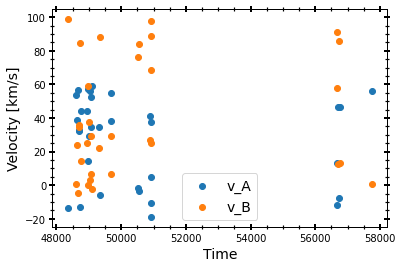

In [4]:
plt.scatter(data.mJD, data.v_A, label='v_A')
plt.scatter(data.mJD, data.v_B, label='v_B')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Velocity [km/s]')

In [41]:
def run_tj(tb, star,chains=2, prior_size=50_000,save=False,MCMC=False):
    data           = Table()
    data['bjd']    = tb['mJD']+2_400_000
    data['rv']     = tb['v_%s'%star]
    data['rv_err'] = tb['sigma_%s'%star]
    print('mean error: %.3f km/s'%np.mean(data['rv_err']))
    
    t = Time(data["bjd"], format="jd", scale="tcb")
    
    rnd = np.random.default_rng(seed=42)
    
    data = tj.RVData(t=t, rv=data["rv"]*u.km/u.s, rv_err=data["rv_err"]*u.km/u.s)
    
    with pm.Model() as model:
        
        prior = tj.JokerPrior.default(
                P_min = 5 * u.day, # to use Joker's default log-normal, give P-min, P-max
                P_max = 200 * u.day,
                sigma_K0 = 50 * u.km / u.s,
                sigma_v = 40 * u.km / u.s,
        )

    prior_samples = prior.sample(size=prior_size, rng=rnd)
    print(prior_samples)
    
    joker = tj.TheJoker(prior, rng=rnd)

    joker_samples = joker.rejection_sample(data, prior_samples, 
                                           max_posterior_samples=256,
                                           return_all_logprobs=True)
    print(joker_samples[0])
    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    _ = tj.plot_rv_curves(
        joker_samples[0],
        data=data,
        relative_to_t_ref=True,
        ax=ax,
    )
    
    ax.set_xlabel(f"BMJD$ - {data.t.tcb.mjd.min():.3f}$")
#     ax.set_xlabel(f"BMJD$ - {data.t.min():.3f}$")
    if save: fig.savefig('../rv_fit/fit_RG%s_%s_2.png'%(obj,DATE),bbox_inches='tight',dpi=100)
    if MCMC:
        
        with prior.model:
            mcmc_init = joker.setup_mcmc(data, joker_samples[0])
            trace = pm.sample(tune=500, draws=4000, start=mcmc_init, cores=1, chains=chains)

        az.summary(trace, var_names=prior.par_names)
        print('MCMC samples...')
        mcmc_samples = tj.JokerSamples.from_inference_data(prior, trace, data)
        mcmc_samples.wrap_K()
        df = mcmc_samples.tbl.to_pandas()
        colnames = []
        # ==== 2 body ====
        #truth = ['P','e','omega','M0','K','v0','s']
        truth = ['P','e','K','v0']
        for name in df.columns:
            if name in truth:
                colnames.append(name)
                #truths.append(truth[name].value)
        fig = corner.corner(df[colnames])#, truths=truths)
        if save: fig.savefig('../rv_fit/corner_RG%s_%s.png'%(obj, DATE),bbox_inches='tight',dpi=200)
    return prior_samples, joker_samples, mcmc_samples, trace, prior.par_names#az.summary(trace, var_names=prior.par_names)



mean error: 3.768 km/s
<JokerSamples [e, omega, M0, s, P] (1000000 samples)>
<JokerSamples [P, e, omega, M0, s, K, v0] (1 samples)>


<ipython-input-41-a5e5f89d0a7f>:47: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(tune=500, draws=4000, start=mcmc_init, cores=1, chains=chains)
Auto-assigning NUTS sampler...
INFO:pymc.sampling.mcmc:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc.sampling.mcmc:Initializing NUTS using jitter+adapt_diag...
Sequential sampling (4 chains in 1 job)
INFO:pymc.sampling.mcmc:Sequential sampling (4 chains in 1 job)
NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]
INFO:pymc.sampling.mcmc:NUTS: [e, __omega_angle1, __omega_angle2, __M0_angle1, __M0_angle2, P, K, v0]


Sampling 4 chains for 500 tune and 4_000 draw iterations (2_000 + 16_000 draws total) took 758 seconds.
INFO:pymc.sampling.mcmc:Sampling 4 chains for 500 tune and 4_000 draw iterations (2_000 + 16_000 draws total) took 758 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
ERROR:pymc.stats.convergence:There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
INFO:pymc.stats.convergence:The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
ERROR:pymc.stats.convergence:The effective sample s

MCMC samples...


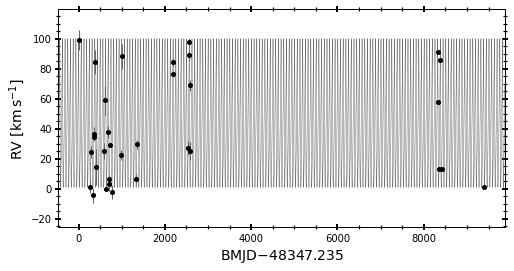

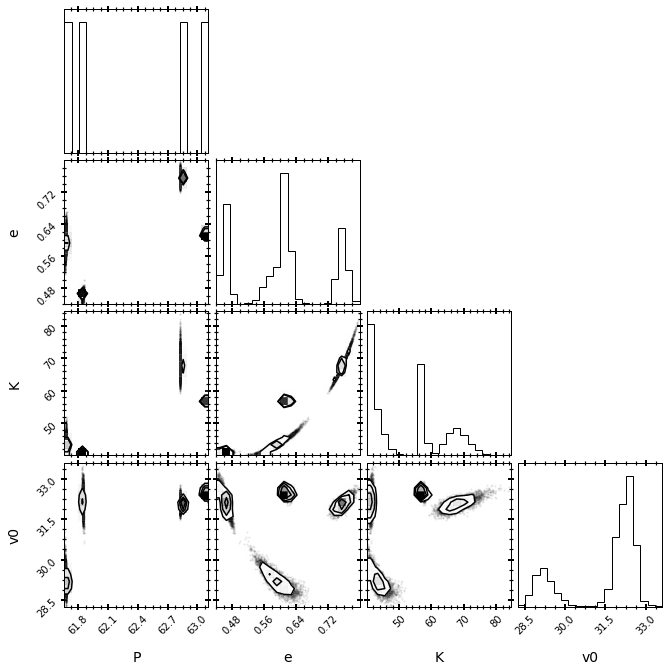

In [42]:
prior_samples, joker_samples, mcmc_samples, trace, names = run_tj(data, 
                                                                  star='B',
                                                                  prior_size = 1_000_000, 
                                                                  chains = 4,
                                                                  save = False, 
                                                                  MCMC = True)


In [30]:

corner_names = ['P', 'e', 'omega', 'M0', 'K', 'v0']


In [38]:
mcmc_samples

<JokerSamples [P, e, omega, M0, s, K, v0, ln_posterior, ln_likelihood, ln_prior] (15997 samples)>

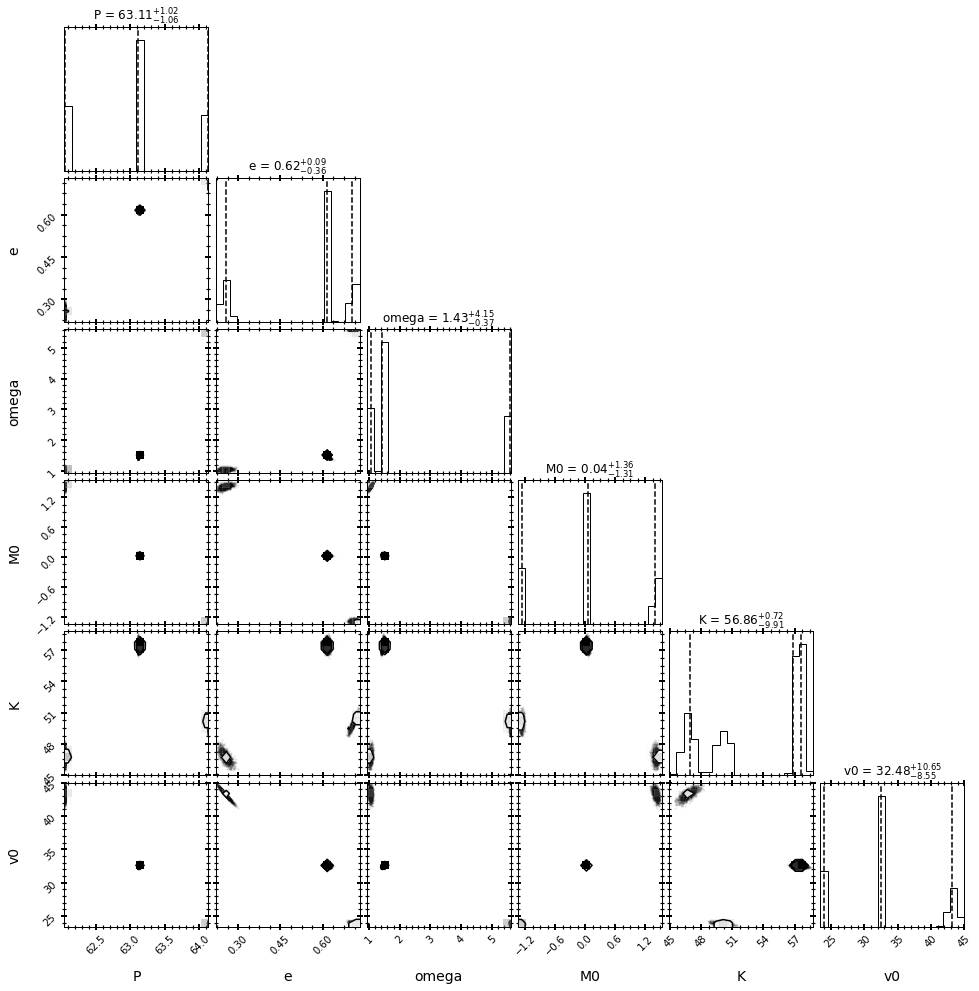

In [31]:

fig = corner.corner(mcmc_samples.tbl.to_pandas()[corner_names], 
                            labels=corner_names,
                            quantiles=[0.16, 0.5, 0.84],
                            show_titles=True,
                            title_kwargs={"fontsize": 12}
                           )

# fig.savefig('../data/claudia/starB_params.png',bbox_inches='tight',dpi=200,facecolor='white')

In [7]:
az.summary(trace, names)

/opt/miniconda3/lib/python3.9/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/opt/miniconda3/lib/python3.9/site-packages/xarray/core/concat.py:527: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
P,62.718,0.214,62.593,63.088,0.107,0.082,7.0,30.0,1.53
e,0.635,0.004,0.627,0.643,0.001,0.001,31.0,2924.0,1.09
omega,1.057,0.140,0.962,1.308,0.070,0.053,7.0,28.0,1.53
M0,0.387,0.075,0.246,0.445,0.037,0.029,7.0,28.0,1.53
s,0.000,0.000,0.000,0.000,0.000,0.000,8000.0,8000.0,NaN
K,-38.754,1.040,-40.657,-37.788,0.508,0.388,7.0,28.0,1.53
v0,32.045,0.475,31.150,32.448,0.234,0.179,7.0,30.0,1.53


In [9]:
version = 1

In [16]:
# save mcmc
save_dir = '../data/claudia/mcmc_%i.pickle' % version
with open(save_dir, 'wb') as handle:
    pickle.dump(mcmc_samples, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save trace
save_dir = '../data/claudia/trace_%i.pickle' % version
with open(save_dir, 'wb') as handle:
    pickle.dump(trace, handle, protocol=pickle.HIGHEST_PROTOCOL)